<a href="https://colab.research.google.com/github/saritmaitra/Momentum_Trading/blob/main/Portfolio_Management_Of_Multiple_Strategies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ***How do we distribute capital among the different strategies and instruments in order to maximise the return and minimise the risk?***

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

plt.style.use('seaborn')
sns.set_palette('cubehelix')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [15, 6]
plt.rcParams['figure.dpi'] = 100
warnings.simplefilter(action='ignore', category=FutureWarning)

!pip install yfinance
import yfinance as yf
import datetime as dt
import matplotlib.transforms as transform
import matplotlib.gridspec as gridspec
import pandas as pd
from pandas.tseries.offsets import MonthEnd
pd.options.mode.chained_assignment = None
pd.set_option('use_inf_as_na', True)
!pip install pyfolio
import pyfolio as pf

import pandas as pd
import numpy as np
import datetime
import math
from tabulate import tabulate
import cvxopt as opt
from cvxopt import blas, solvers
import cvxpy as cp


## Asset Allocation 
Evaluating the performance of a basic 1/n portfolio

To have a benchmark with which to compare our optimization we will start from the simple portfolio distributing the same weight for each of its elements.

For the optimization of weights in the capital distribution, there are numerous academic studies, each one trying to optimize different parameters.

Two of the best known and diametrically opposed methods are:

- The efficient frontier proposed by Markowitz in which we try to maximize the return with a certain risk, i.e. it focuses on containing the assigned risk.
- Kelly's method proposed by John Kelly and Ed Thorpe that tries to maximise the expectation of the log utility of wealth, i.e. maximizing return is the focus.

[*********************100%***********************]  8 of 8 completed
Downloaded 505 rows of data.


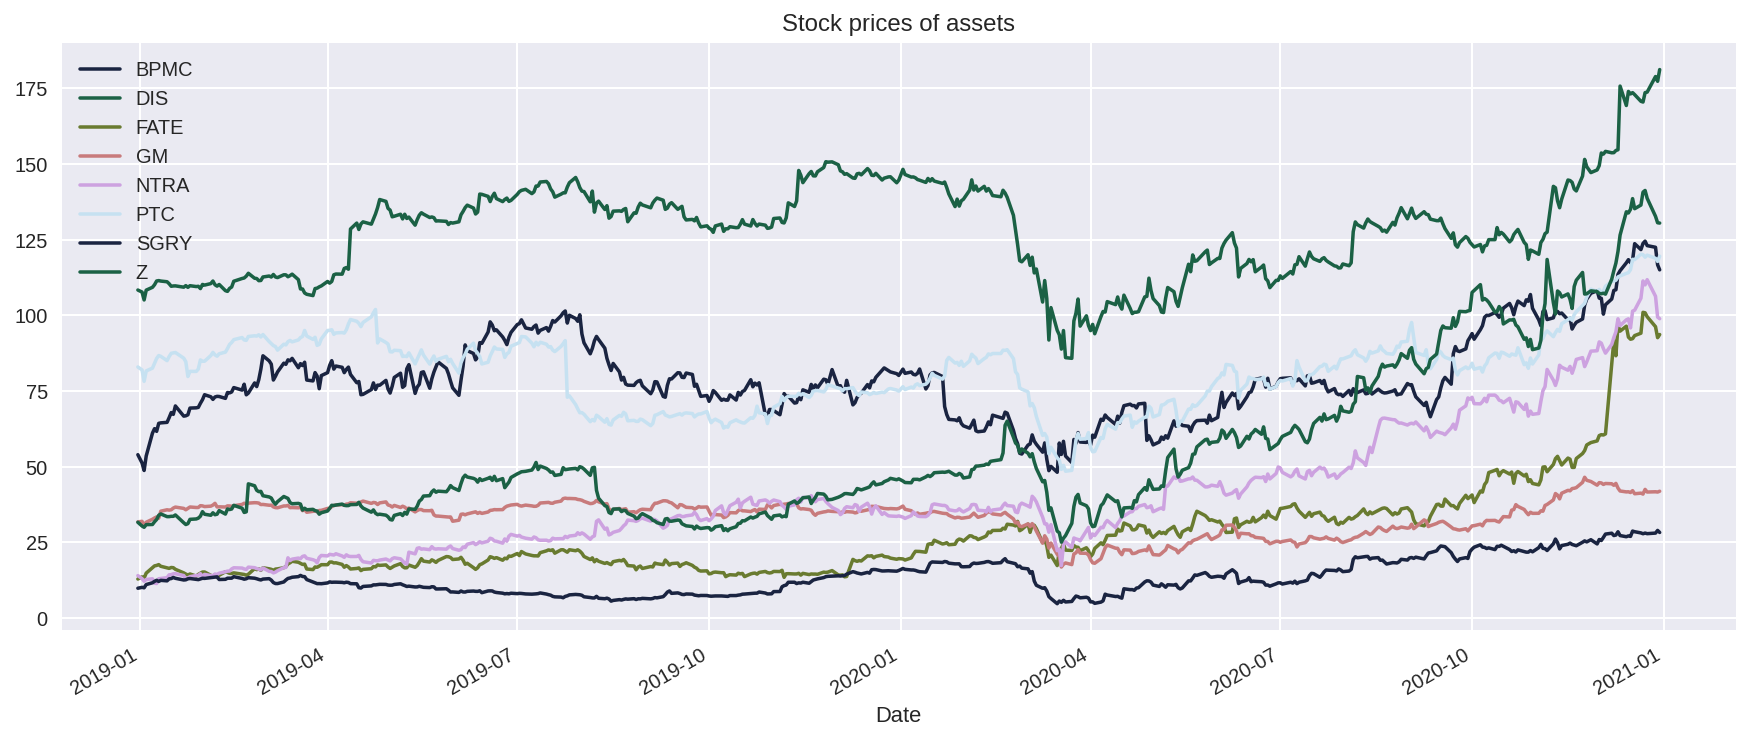

In [35]:
tickers=["SGRY", "NTRA", "Z", "FATE", "DIS", "GM", 'BPMC', "PTC"]
start = dt.datetime(2018,12,31)
end = dt.datetime(2020,12,31) # dt.datetime.now()
n_assets = len(tickers)

prices = yf.download(tickers, start=start, 
                        end=end, adjusted=True,
                     index_col='Date',
                  parse_dates=True)
print(f'Downloaded {prices.shape[0]} rows of data.')
prices['Adj Close'].plot(title='Stock prices of assets', figsize= (15,6))
plt.show()

## Efficient Portfolios
An efficient portfolio is defined as a portfolio with minimal risk for a given return, or, equivalently, as the portfolio with the highest return for a given level of risk.

When we only have one strategy managing one instrument, portfolio management is limited to maximizing return while minimizing risk. This would be the simplest portfolio, but not a simple solution.

It is not a simple solution because we have to answer some questions.
- Can we achieve the desired return with the instrument we are working with?
- Are there other instruments that allow us to achieve a higher return with the same risk or less risk with the same return?

On the other hand, if we want to diversify the portfolio and therefore reduce the risk associated with the strategy or instrument, we must build a portfolio with different instruments and ideally different strategies that capture different market regimes.

Therefore, in addition to the above questions, we need to answer 
- what weight we assign to each strategy and what weight we give to each instrument within the portfolio to achieve the required objective (Max return vs Min risk).

## Portfolio's Elements
Let's define the portfolio's elements which we have some control over them:

- Capital: The amount of money we have available to invest or speculate.
Instruments: These are the assets available for inclusion in our portfolio management strategy.
- Currency: The currency in which the asset is traded. When we invest in an asset denominated in a foreign currency, we assume the foreign exchange risk.
- Volatility: Also called asset risk, indicates the movement of the asset for the period analysed.
- Cost: Amount of money needed to buy/sell-short an asset.
Liquidity: It is the capacity of the asset to absorb our operations.
- Rules: These are the strategies that try to take advantage of some market regime.
- Position weight: The amount of capital we allocate to each asset and/or strategy.
- Return: Absolute returns are the return of our portfolio and relative returns are the return of our portfolio compared to a benchmark. When we are not comparing our returns with anybody, absolute return is a good measure, but when we need to compare performances we use the relative return.
- Risk or Volatility: This is the (estimated) amount that the portfolio assumes.

## Portfolio performance measures
Algorithmic traders have at their disposal a large number of measures to analyze the strategy and/or the portfolio performance.

Some of the most used Portfolio performance measures are:

- Annualised Returns
- Annualised Volatility
- Sharpe Ratio
- Sortino Ratio
- Beta
- Treynor Ratio
- Information Ratio
- Skewness
- Kurtosis
- Maximum Drawdown
- Number of Trades
- Profit ratio
- Holding period

## Building a simple portfolio
To build our example portfolio we are going to use a random time series generated to simulate the return of two strategies over several instruments.

- Strategy 1 - The first strategy, that we will call A, is a trend follower system and as it's typical in these strategies, it has a positive bias.
- Strategy 2 - The second strategy, that we will call B, is a mean reversion system and as it's typical in these strategies, it has a negative bias.

## Role of Bias
The bias or skew is an important concept to characterize the behaviour of the strategy, as it is an indicator of the returns' distribution.

### Positive Bias
When we have a positive bias it means that we are having small frequent losses but we capture the infrequent outliers of the distribution. This behaviour is typical of a trend following system since we have frequent false signals with small losses and infrequent large returns, or what is the same, cuts losses quickly and lets the gains run.

### Negative Bias
When we have a negative bias it means that we are having small frequent gains and occasional large losses. This behaviour is typical of mean reversion, arbitrage, sell options or similar systems, i.e. we have a system that systematically collects small profits and throws infrequent large losses.

## Strategies to be used
In this post, we will work directly with the returns strategies.

It is needless to say that any strategy that is considered to be part of the portfolio has had to pass backtesting that offers us an adequate level of uncertainty.

## About the instruments or assets
Assets are the main elements of a portfolio and their characteristics are decisive for obtaining the determined risk/benefit ratio. Some of the most important characteristics are:

- Currency
- Volatility
- Liquidity
- Cost
- Commission
- Slippage
- Correlation (in relation to other assets)

## Strategy A - Trend following system - BPMC

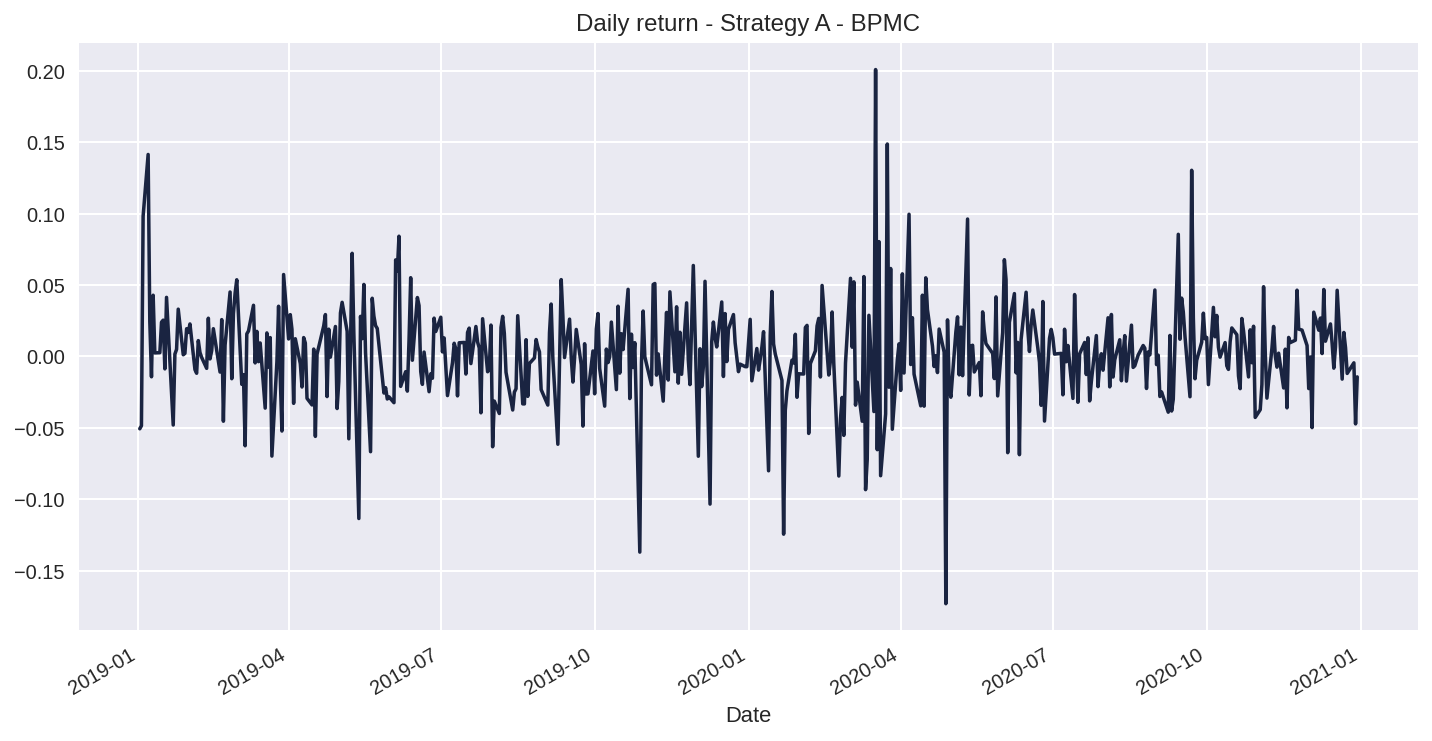

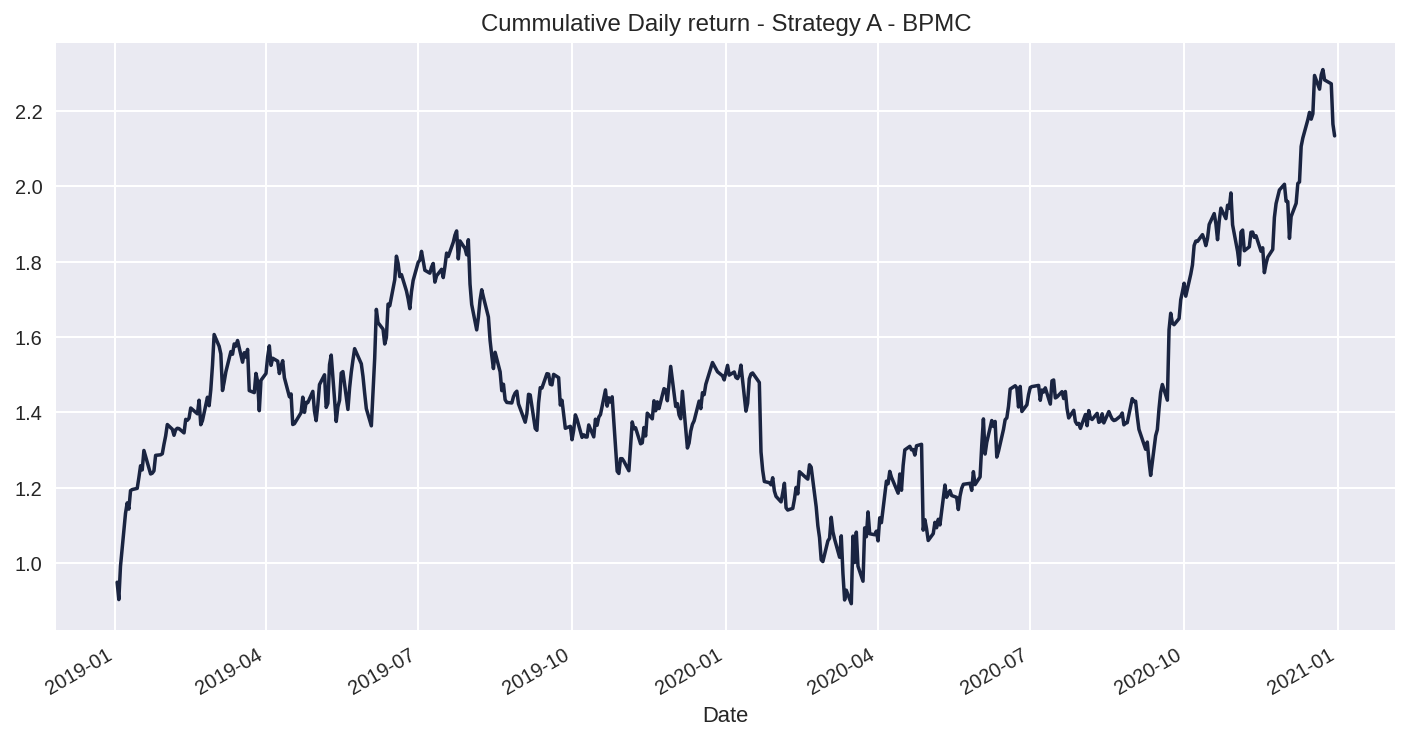

In [3]:
StrategyA1_returns = prices['Adj Close']['BPMC'].pct_change().dropna()
# print(StrategyA1_returns.head())
StrategyA1_returns.plot(title = 'Daily return - Strategy A - BPMC', figsize=(12, 6))
plt.show()

cum_daily_return = (StrategyA1_returns+1).cumprod()
cum_daily_return.plot(title = 'Cummulative Daily return - Strategy A - BPMC', figsize=(12, 6))
plt.show()

In [4]:
bpmc_volatility = StrategyA1_returns.std() * np.sqrt(252) 
sharp_ratio = (StrategyA1_returns.mean() - 0.05) / bpmc_volatility
print('Sharp ratio:', round(sharp_ratio, 2))
print('Skewness:', round(prices['Adj Close']['BPMC'].skew(), 2))

Sharp ratio: -0.09
Skewness: 0.71


## Strategy A - Trend following system - NTRA

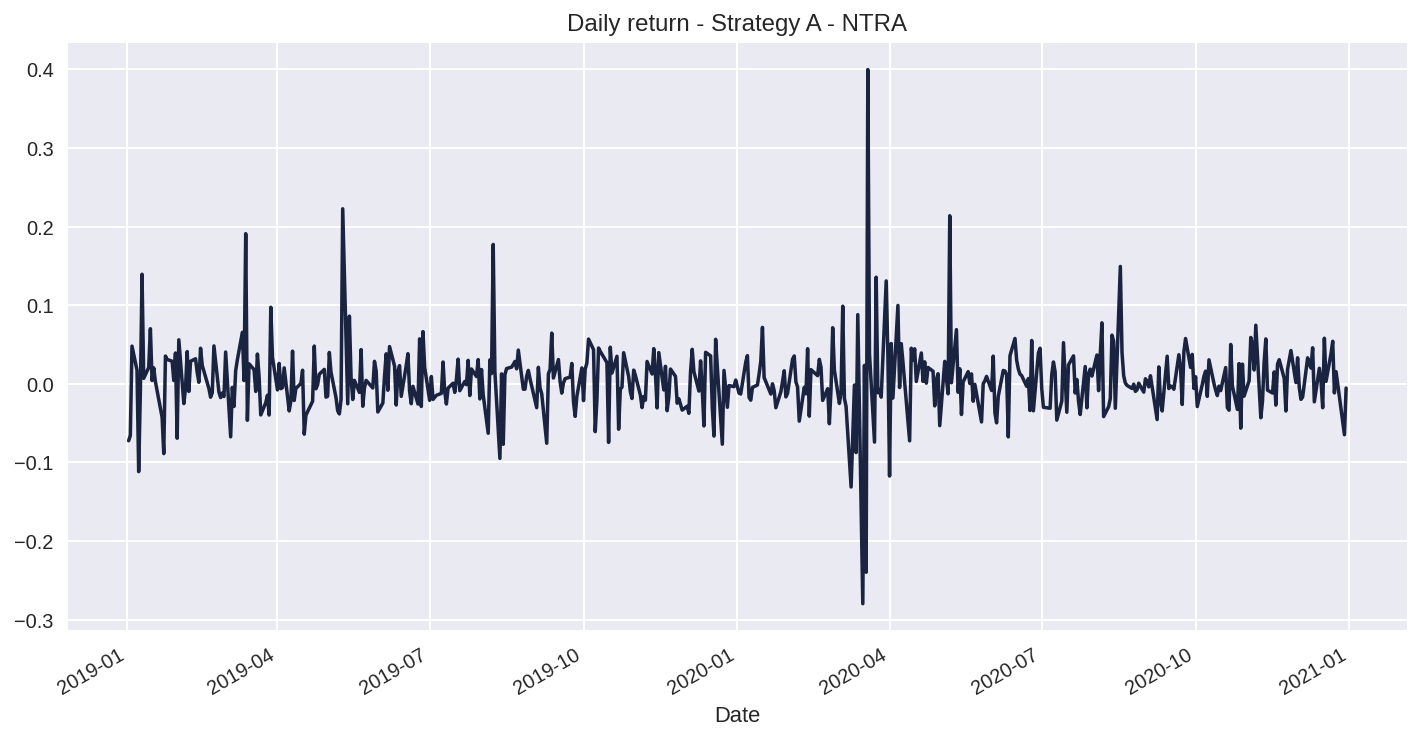

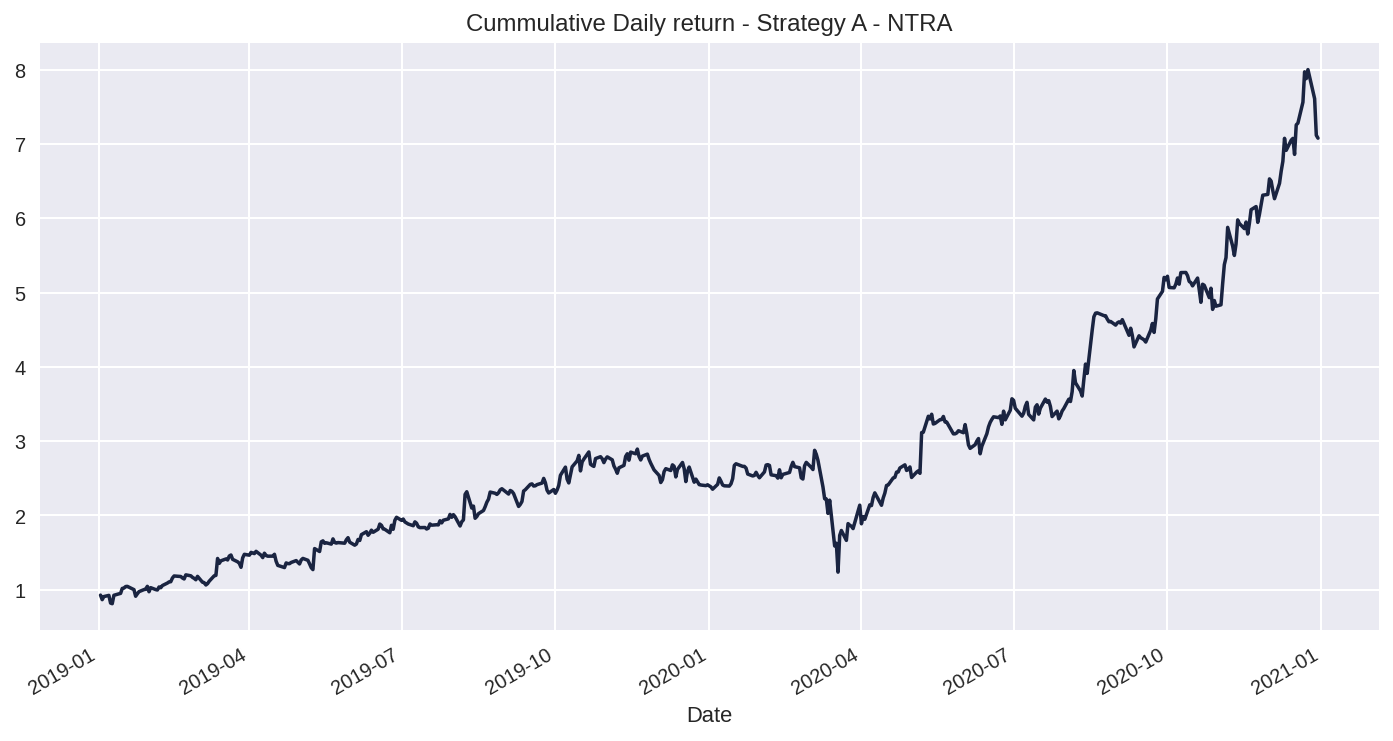

In [5]:
StrategyA2_returns = prices['Adj Close']['NTRA'].pct_change().dropna()
# print(StrategyA1_returns.head())
StrategyA2_returns.plot(title = 'Daily return - Strategy A - NTRA', figsize=(12, 6))
plt.show()

cum_daily_return = (StrategyA2_returns+1).cumprod()
cum_daily_return.plot(title = 'Cummulative Daily return - Strategy A - NTRA', figsize=(12, 6))
plt.show()

In [6]:
ntra_volatility = StrategyA2_returns.std() * np.sqrt(252) 
sharp_ratio = (StrategyA2_returns.mean() - 0.05) / ntra_volatility
print('Sharp ratio:', round(sharp_ratio, 2))
print('Skewness:', round(prices['Adj Close']['NTRA'].skew(), 2))

Sharp ratio: -0.06
Skewness: 1.22


## Strategy A - Trend following system - SGRY

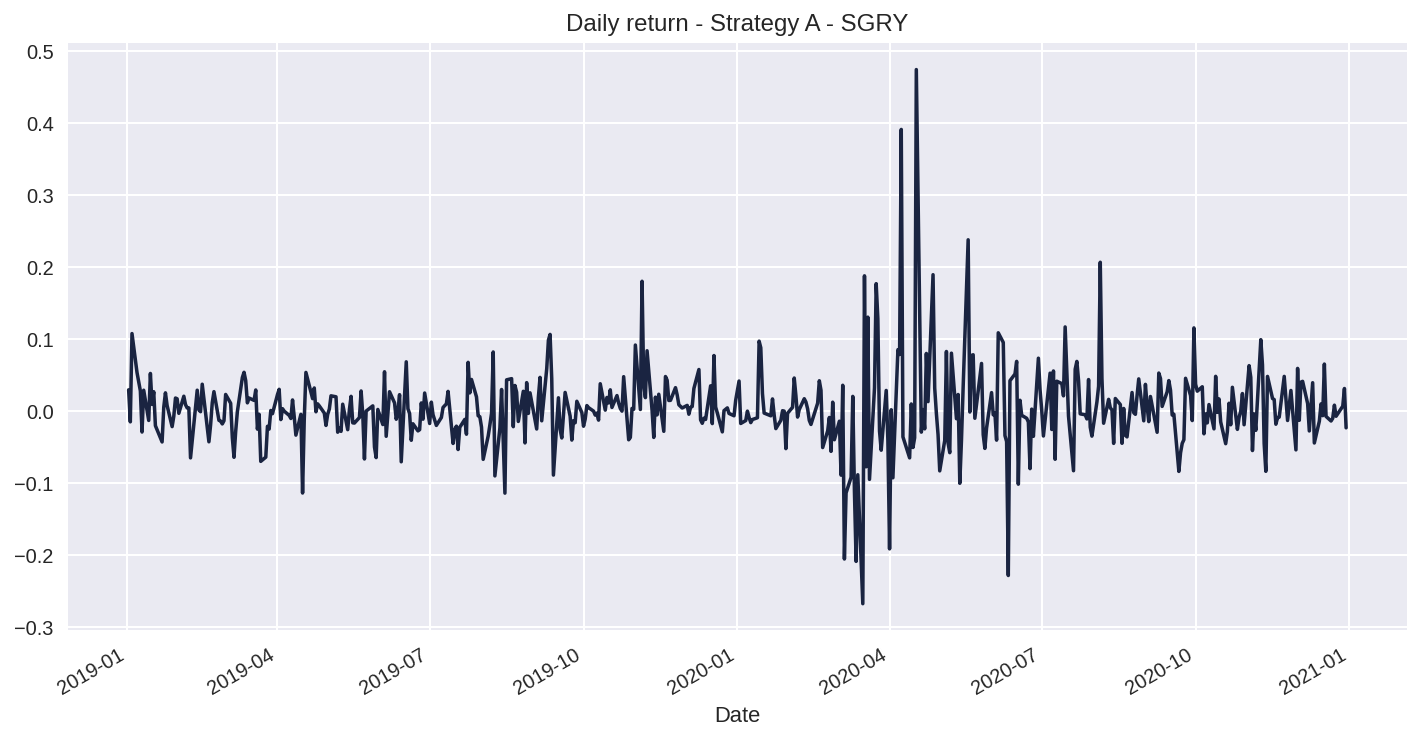

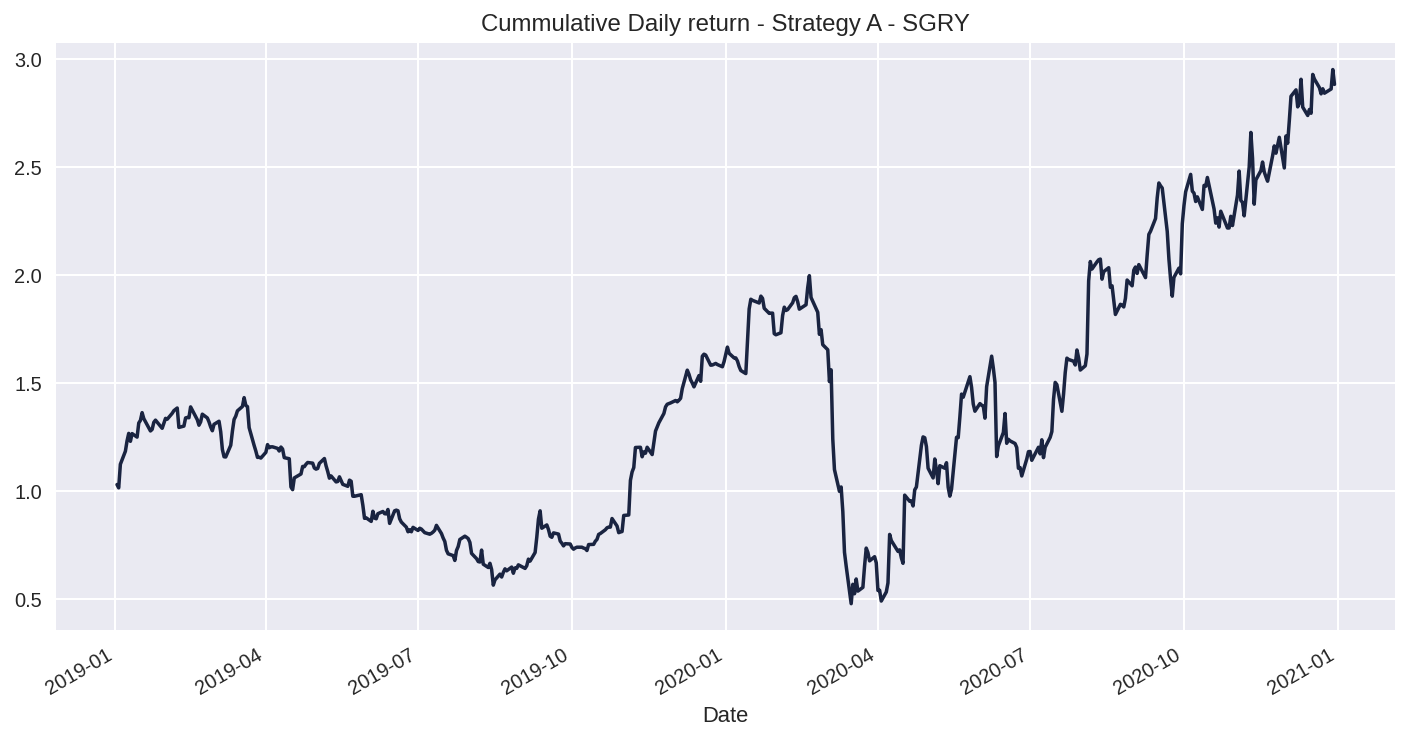

In [7]:
StrategyA3_returns = prices['Adj Close']['SGRY'].pct_change().dropna()
# print(StrategyA1_returns.head())
StrategyA3_returns.plot(title = 'Daily return - Strategy A - SGRY', figsize=(12, 6))
plt.show()

cum_daily_return = (StrategyA3_returns+1).cumprod()
cum_daily_return.plot(title = 'Cummulative Daily return - Strategy A - SGRY', figsize=(12, 6))
plt.show()

In [8]:
sgry_volatility = StrategyA3_returns.std() * np.sqrt(252) 
sharp_ratio = (StrategyA3_returns.mean() - 0.05) / sgry_volatility
print('Sharp ratio:', round(sharp_ratio, 2))
print('Skewness:', round(prices['Adj Close']['SGRY'].skew(), 2))

Sharp ratio: -0.05
Skewness: 0.76


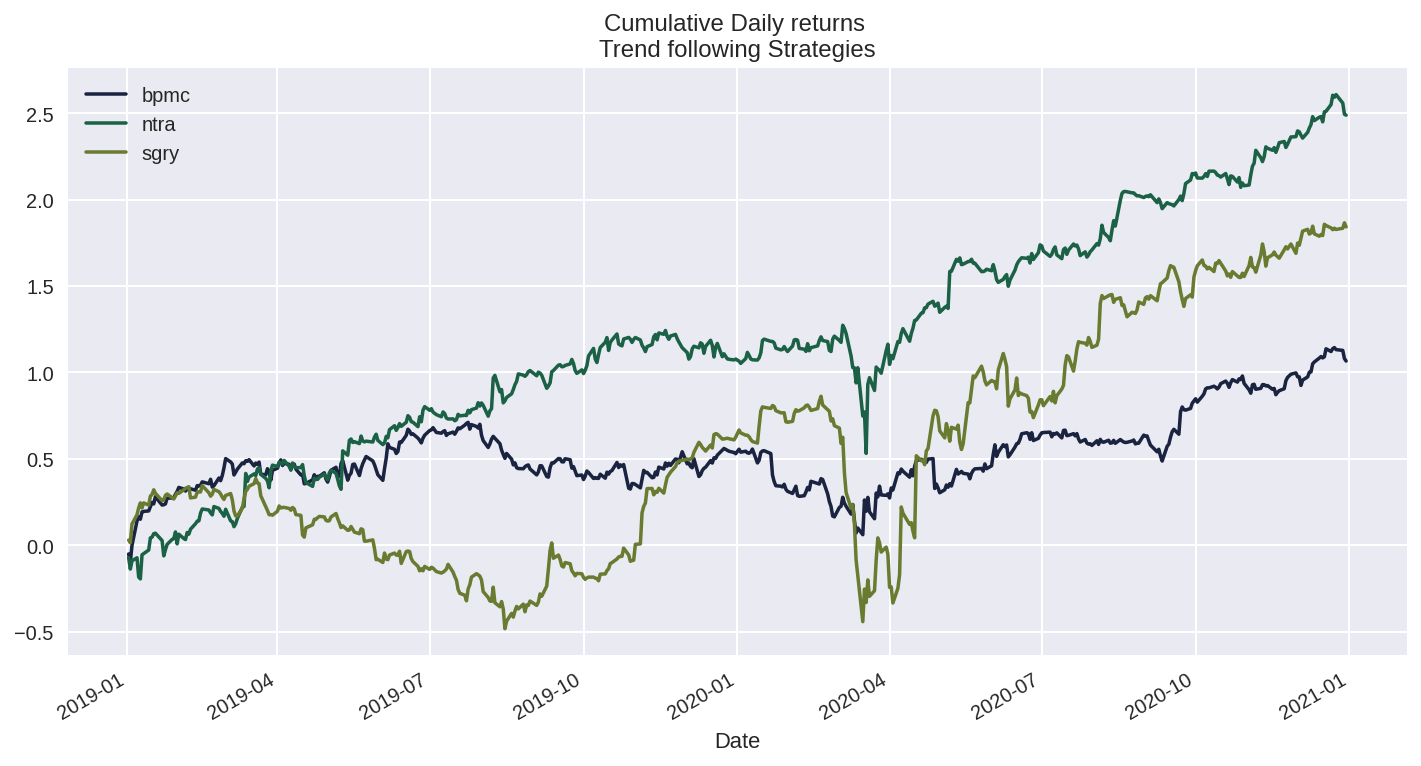

In [9]:
first_strat = pd.concat([StrategyA1_returns, StrategyA2_returns, StrategyA3_returns], axis=1, ignore_index=False)
first_strat.columns=['bpmc', 'ntra', 'sgry']
first_strat.cumsum().plot(title = 'Cumulative Daily returns \nTrend following Strategies', figsize=(12, 6))
plt.show()

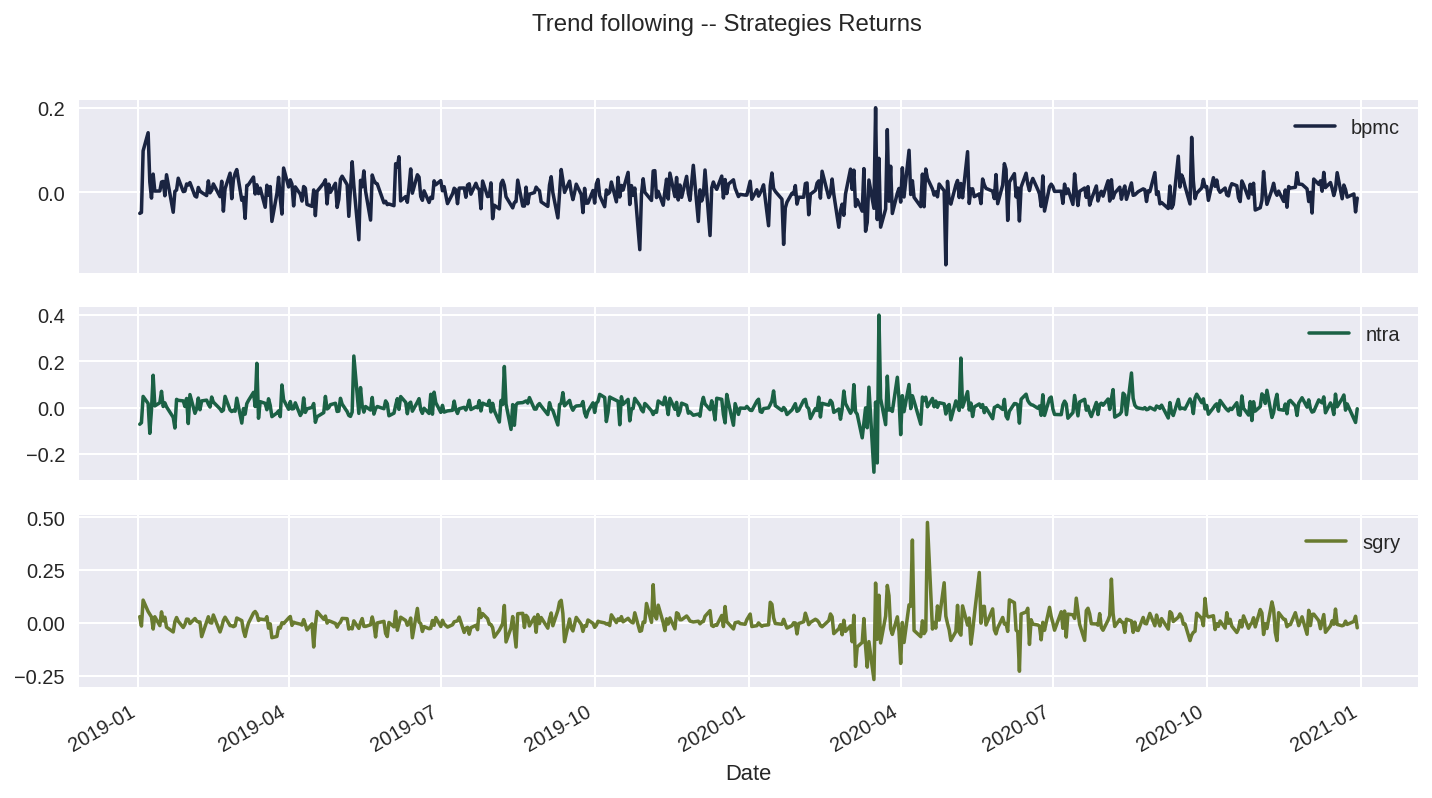

In [10]:
first_strat.plot(title="Trend following -- Strategies Returns", figsize=(12,6),subplots=True)
plt.show()

In [11]:
# decriptive statistics
first_strat.describe()

bpmc        ntra        sgry
count  504.000000  504.000000  504.000000
mean     0.002115    0.004937    0.003655
std      0.034987    0.046255    0.056901
min     -0.173061   -0.279545   -0.267606
25%     -0.015677   -0.016930   -0.019992
50%      0.002540    0.003132    0.000000
75%      0.019649    0.025882    0.026063
max      0.200790    0.399537    0.474654

In [12]:
# Return distribution
first_strat.kurtosis()

bpmc     4.922857
ntra    16.486087
sgry    16.028766
dtype: float64

In [13]:
# skewness
first_strat.skew()

bpmc    0.132816
ntra    1.097338
sgry    1.594780
dtype: float64

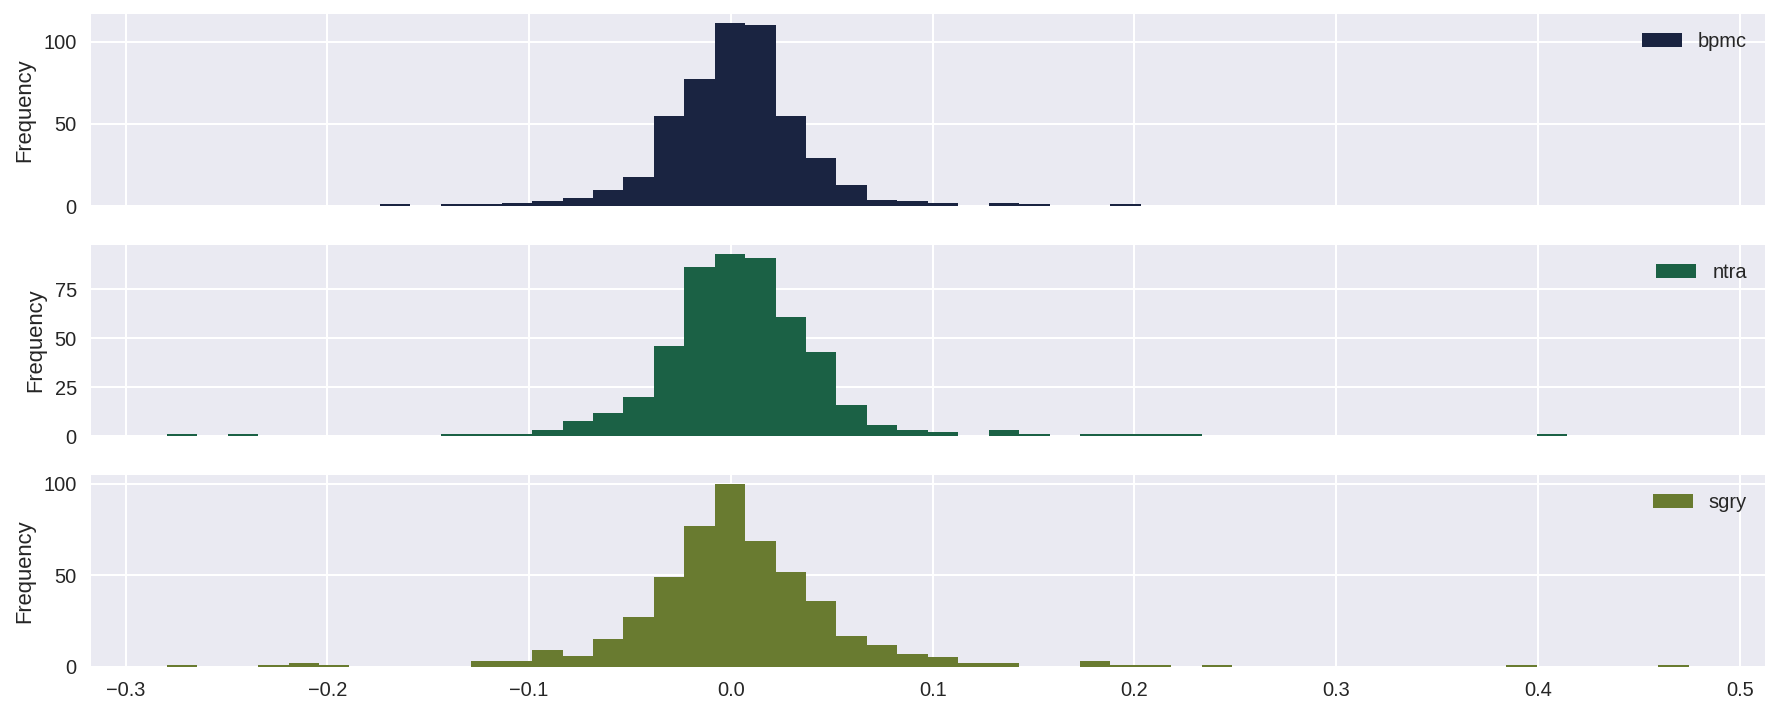

In [14]:
# distribution of each 
first_strat.plot(kind="hist", bins=50, subplots=True, figsize=(15,6))
plt.show()

correlation is important to know when asset or strategy returns go hand in hand in future luck. To benefit from diversification, the correlation must be 'low'.


In [15]:
corr = first_strat.corr()
print(corr)

         bpmc      ntra      sgry
bpmc  1.00000  0.348170  0.303480
ntra  0.34817  1.000000  0.249391
sgry  0.30348  0.249391  1.000000


In [16]:
# analyze the correlation based on the time horizon we have as an investment
corr = first_strat[-60:].corr()
print(corr)

          bpmc      ntra      sgry
bpmc  1.000000  0.274940 -0.093921
ntra  0.274940  1.000000 -0.174976
sgry -0.093921 -0.174976  1.000000


The above analyses give us a snapshot at a given time for a given horizon, but the reality is that the correlation varies over time and knowing this allows us to make better estimates.

we can see that the correlation is different if we consider a year:

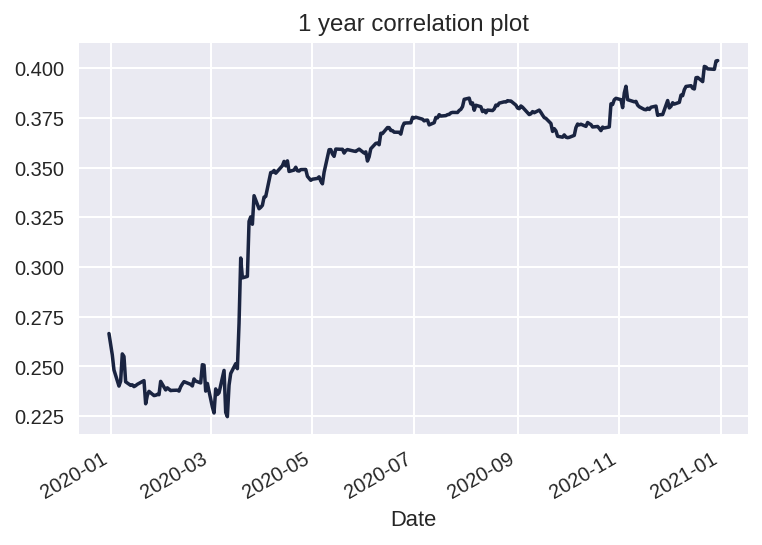

In [17]:
first_strat['bpmc'].rolling(252).corr(first_strat['ntra']).plot()
plt.title('1 year correlation plot')
plt.show()

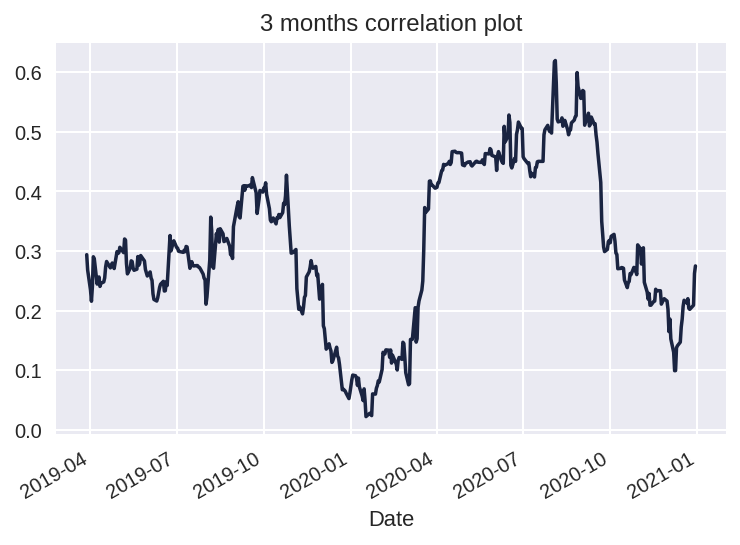

In [18]:
# A quarter's correlation is greater than the annual correlation.
first_strat['bpmc'].rolling(60).corr(first_strat['ntra']).plot()
plt.title('3 months correlation plot')
plt.show()

If we reduce the horizon to two weeks, we see that the correlation is quite high. Therefore, we see that the correlation is closely related to the analysis horizon.

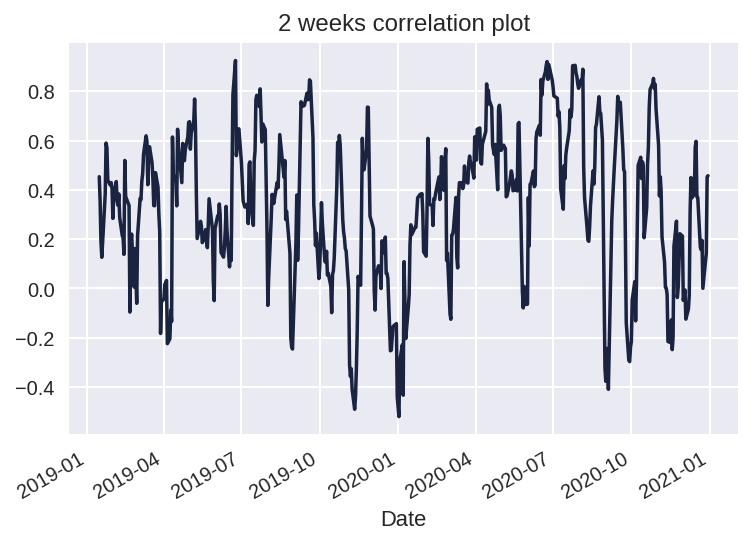

In [19]:
# A quarter's correlation is greater than the annual correlation.
first_strat['bpmc'].rolling(10).corr(first_strat['ntra']).plot()
plt.title('2 weeks correlation plot')
plt.show()

In [ ]:
# remove your installed pyfolio library
!pip uninstall pyfolio

# Install it again from its github repo
!pip install git+https://github.com/quantopian/pyfolio

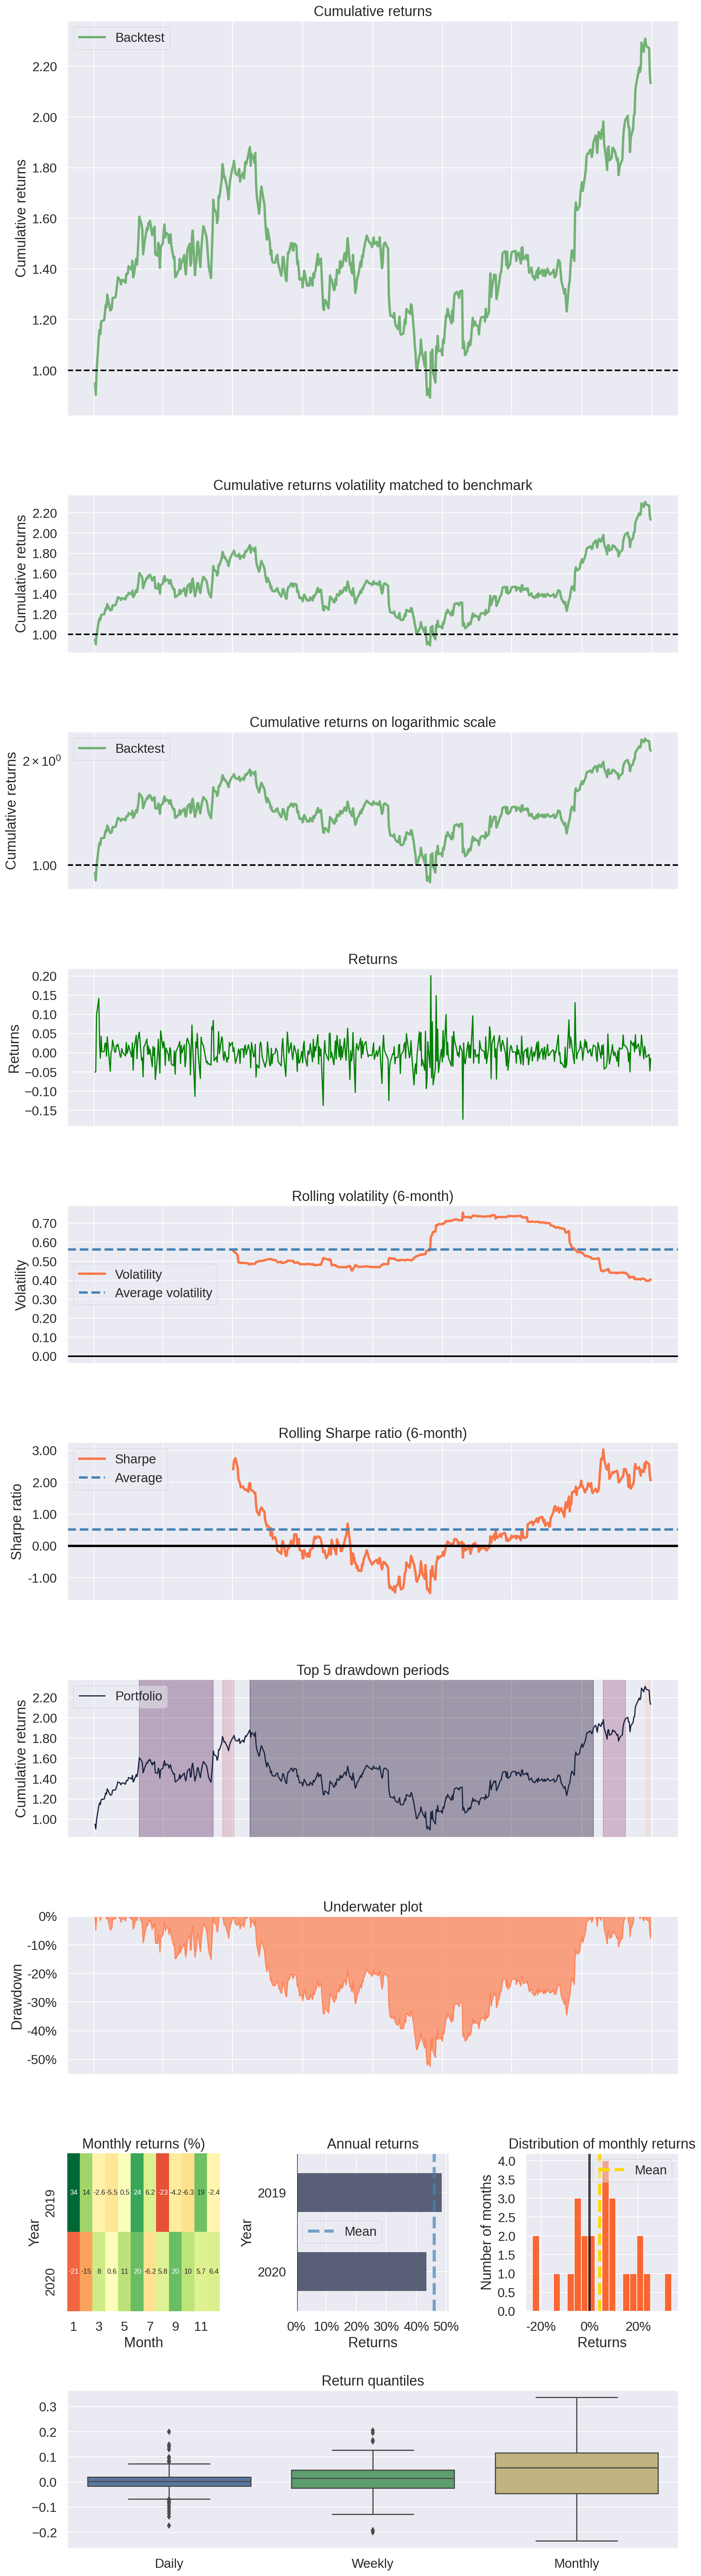

In [21]:
import pyfolio as pf
# performance analysis
pf.tears.create_returns_tear_sheet(pd.Series(first_strat['bpmc']))

## Equal weighted portfolio
The problem we are dealing with is knowing how to distribute the available capital between each of the portfolio strategies that have passed the mandatory robust backtesting.

To know if we are doing well, we need something to compare ourselves with, the benchmark, and it must have characteristics similar to what we want to compare.

For example, the trend following system should be compared with a strategy of buying and holding a portfolio with the same assets.

Here we are going to create a portfolio whose weights are identical for each of the instruments, not differentiate the type of strategy. It serves as a basis for comparing the balance of weights that we will be testing.

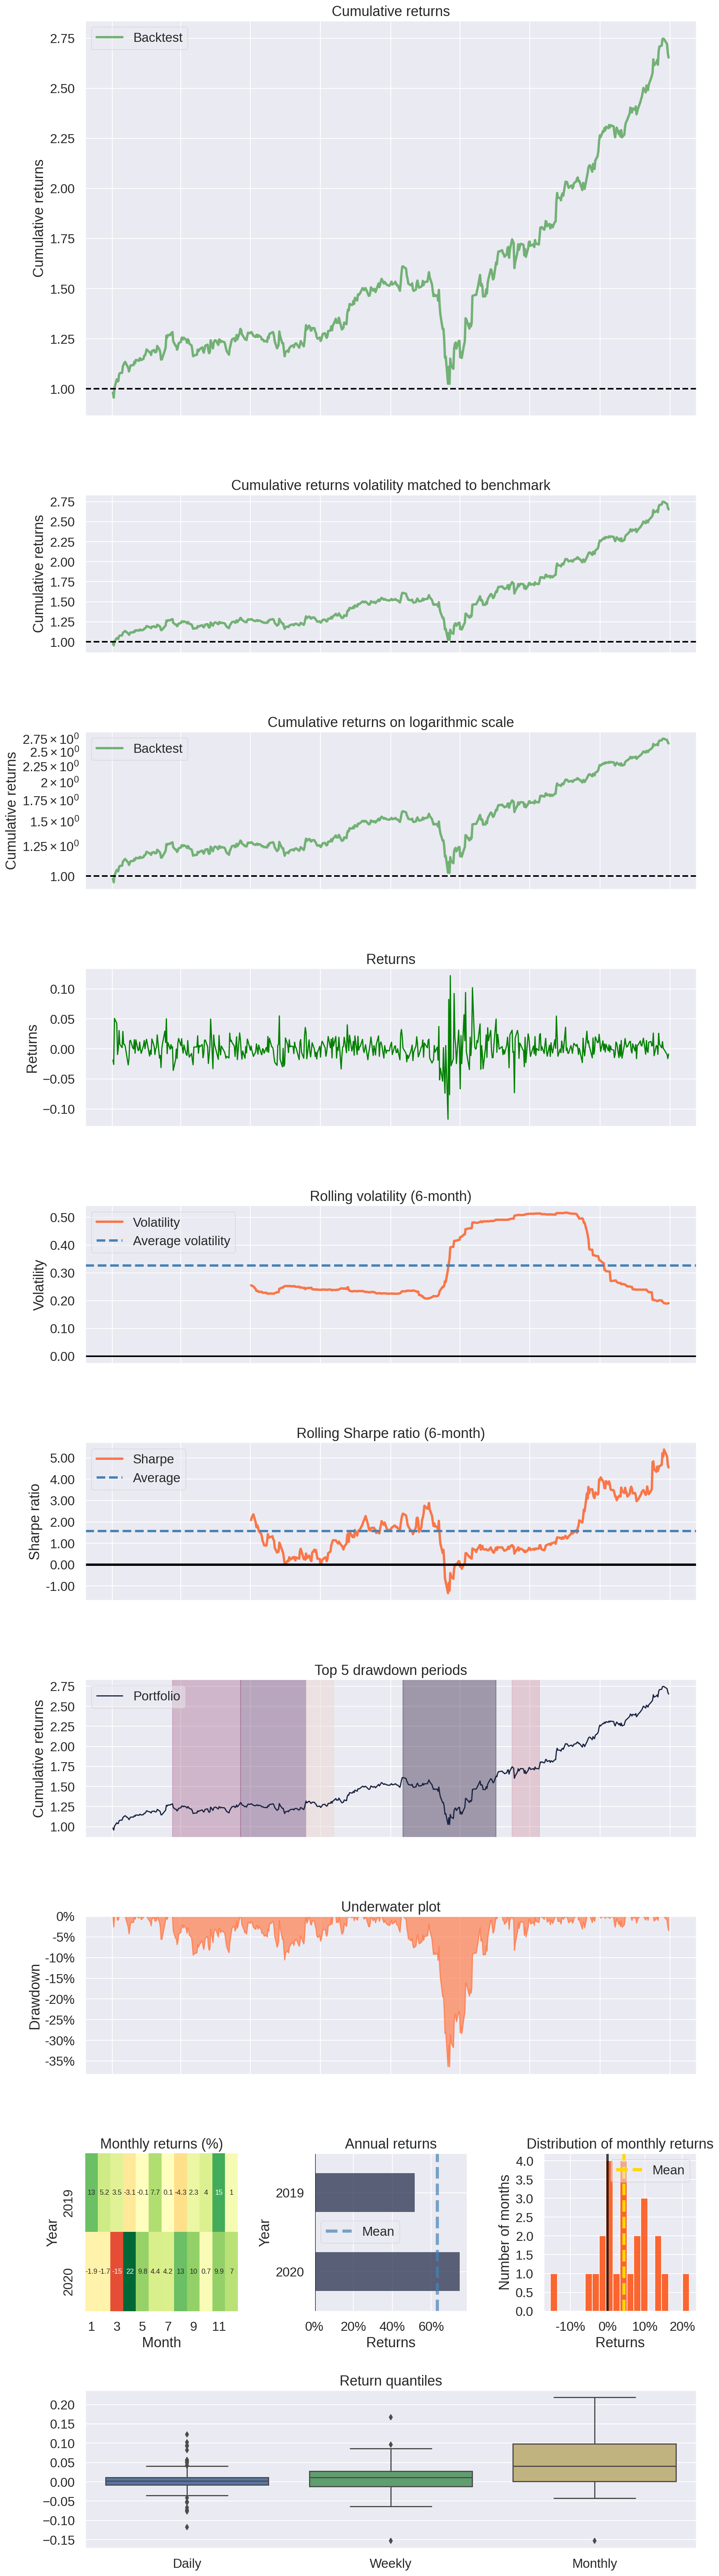

In [23]:
portfolio_total_return = np.sum([0.2, 0.2, 0.2] * first_strat, axis=1)
pf.tears.create_returns_tear_sheet(pd.Series(portfolio_total_return))

## Portfolio weights optimized with Kelly criterion
Kelly's criterion is one of the methods available to estimate the weights of our portfolio and maximize the benefit with minimum risk for the analyzed portfolio.


In [24]:
no_of_stocks = first_strat.shape[1]
print(no_of_stocks)

3


In [25]:
# Compute the variable to get the weights
weights = cp.Variable(no_of_stocks)
weights.shape

(3,)

In [26]:
# The portfolio returns are based on the daily return multiplied by the weight for each asset.
portfolio_returns = (np.array(first_strat)*weights)
print(portfolio_returns)

[[-0.05063995 -0.07234959  0.02962206]
 [-0.04845642 -0.06563702 -0.01488091]
 [ 0.09815192  0.04793388  0.10775425]
 ...
 [-0.00447157 -0.04904238  0.00682964]
 [-0.04720293 -0.06465276  0.03141732]
 [-0.01431386 -0.00543315 -0.02319142]] * var0


## Kelly Criterion
The final portfolio value or the utility of the portfolio can be computed using the logarithmic summation of the daily portfolio returns.

In [27]:
final_portfolio_value = cp.sum(cp.log(1+portfolio_returns))
print(final_portfolio_value)

Sum(log(1.0 + [[-0.05063995 -0.07234959  0.02962206]
 [-0.04845642 -0.06563702 -0.01488091]
 [ 0.09815192  0.04793388  0.10775425]
 ...
 [-0.00447157 -0.04904238  0.00682964]
 [-0.04720293 -0.06465276  0.03141732]
 [-0.01431386 -0.00543315 -0.02319142]] * var0), None, False)


The output tells us that the final_portfolio_value is an expression and is concave in nature and its value is unknown

The objective of this example is to maximise the Kelly criterion. To do this, you can create a parameter called 'objective' and assign the maximisation condition to it. The Maximize function of the cvxpy library is used for this purpose.

In [28]:
objective = cp.Maximize(final_portfolio_value)
print(objective)

maximize Sum(log(1.0 + [[-0.05063995 -0.07234959  0.02962206]
 [-0.04845642 -0.06563702 -0.01488091]
 [ 0.09815192  0.04793388  0.10775425]
 ...
 [-0.00447157 -0.04904238  0.00682964]
 [-0.04720293 -0.06465276  0.03141732]
 [-0.01431386 -0.00543315 -0.02319142]] * var0), None, False)


The output tells us that the objective is a Maximize function over the expression. The expression is concave in nature and its value is unknown

We need to remember that there are certain constraints on the weights of the portfolio.

- The weights should positive, as you are considering to use a strategy or not.
- The sum of weights should be less than or equal to 1, as you are not considering leveraging.

In [29]:
constraints = [0.0 <= weights, cp.sum(weights) == 1]
print(constraints)

[Inequality(Constant(CONSTANT, ZERO, ())), Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, NONNEGATIVE, ()))]


Here the constraints specify that the first one is an inequality constraint and its value is a constant zero. While the second is an equality constraint between an affine expression whose value is equal to a constant non-negative value

Now, we can combine both the objective and the constraints to create a problem statement. We can do this by using the Problem class of the cvxpy library, as shown below.

In [30]:
problem = cp.Problem(objective, constraints)
print(problem)

maximize Sum(log(1.0 + [[-0.05063995 -0.07234959  0.02962206]
 [-0.04845642 -0.06563702 -0.01488091]
 [ 0.09815192  0.04793388  0.10775425]
 ...
 [-0.00447157 -0.04904238  0.00682964]
 [-0.04720293 -0.06465276  0.03141732]
 [-0.01431386 -0.00543315 -0.02319142]] * var0), None, False)
subject to 0.0 <= var0
           Sum(var0, None, False) == 1.0


Here the output describes the entire problem including all the previously described expression into a one single statement

We can use the solve method of the problem class to get the best weight combination as shown below:

In [31]:
# The optimal objective value is returned by `prob.solve()`.
problem.solve()

# The optimal value for w is stored in `w.value`.
print(weights.value)

[4.58555002e-12 9.72441210e-01 2.75587896e-02]


These are the optimal weights according to Kelly's criterion, as we can see the first two strategies have such a small weight that we discard them and simplified, we can say that the remaining three have a similar weight.

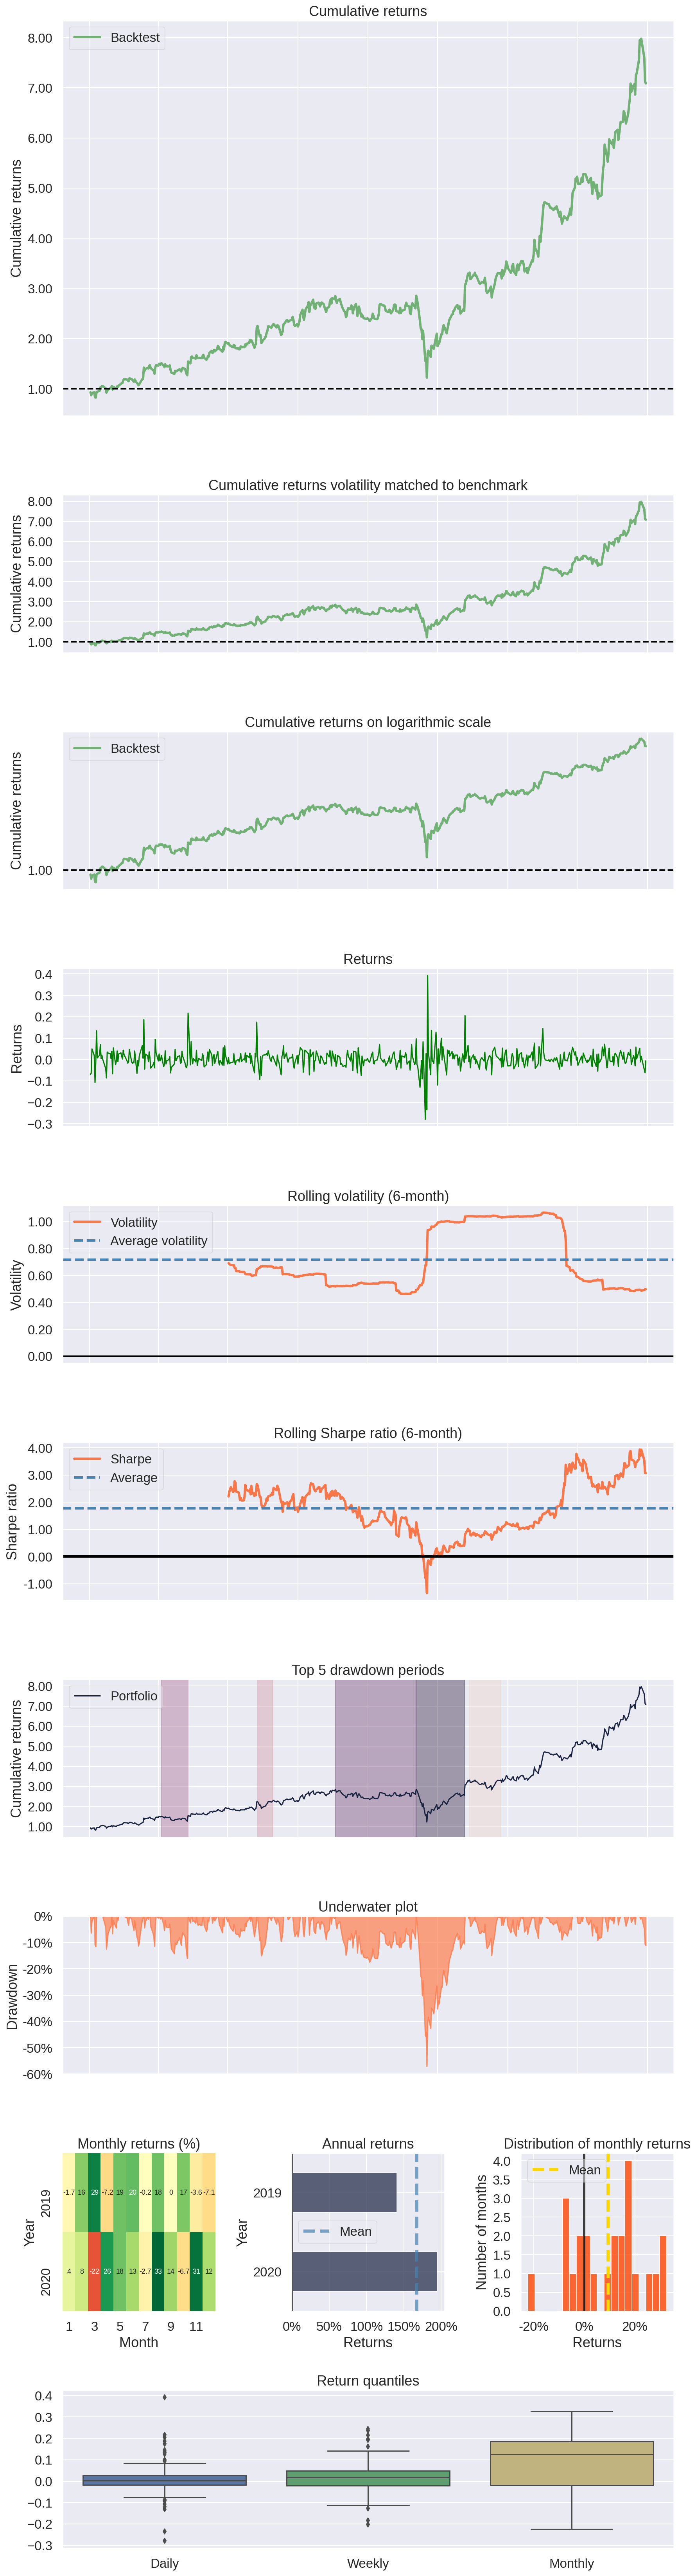

In [33]:
portfolio_total_return_kelly = np.sum(weights.value * first_strat, axis=1)
pf.tears.create_returns_tear_sheet(portfolio_total_return_kelly)

If we compare it with the initial portfolio with the equally distributed weights, we see that Kelly's optimization has improved the annualized return, the cumulative one, the SR and increased the volatility.

